<a href="https://colab.research.google.com/github/petergchang/ssm-jax/blob/main/ssm_jax/nlgssm/demos/pendulum.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 2D Pendulum Tracking Example for NLGSSM

This notebook demonstrates a simple 2d pendulum tracking example for EKF, UKF, SLF, and PF.

Simo Särkkä (2013), “Bayesian Filtering and Smoothing,” Cambridge University Press. Available: https://users.aalto.fi/~ssarkka/pub/cup_book_online_20131111.pdf

This JAX translation is by Peter G. Chang ([@petergchang](https://github.com/petergchang)) and taken from the [särkkä-jax](https://github.com/petergchang/sarkka-jax) repo.



## 0. Imports and Formatting

In [1]:
# TODO: Change to https://github.com/probml/ssm-jax.git after PR merged
!git clone https://github.com/petergchang/ssm-jax.git
%cd ssm-jax
!pip install -e .
%cd ssm_jax/nlgssm

Cloning into 'ssm-jax'...
remote: Enumerating objects: 716, done.
remote: Counting objects: 100% (177/177), done.
remote: Compressing objects: 100% (139/139), done.
remote: Total 716 (delta 84), reused 81 (delta 36), pack-reused 539
Receiving objects: 100% (716/716), 2.65 MiB | 18.43 MiB/s, done.
Resolving deltas: 100% (412/412), done.
/content/ssm-jax
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Obtaining file:///content/ssm-jax
     |████████████████████████████████| 140 kB 11.9 MB/s 
     |████████████████████████████████| 72 kB 275 kB/s 
     |████████████████████████████████| 272 kB 41.2 MB/s 
  Running setup.py develop for ssm-jax
/content/ssm-jax/ssm_jax/nlgssm


In [5]:
%matplotlib inline
import matplotlib.pyplot as plt

import chex
import jax
import jax.numpy as jnp
import jax.random as jr
from jax import vmap
from jax import lax
from jax import jacfwd
from typing import Callable

import extended_inference as extended

In [3]:
# For pretty print of ndarrays
jnp.set_printoptions(formatter={'float_kind':"{:.2f}".format})

## 1. Simulation and Plotting

We simulate the pendulum data using the following transition model:
\begin{align*}
  \begin{pmatrix} x_{1,k} \\ x_{2,k} \end{pmatrix} &= 
  \begin{pmatrix} x_{1,k-1} + x_{2,k-1} \Delta t \\
    x_{2,k-1} - g \sin(x_{1,k-1}) \Delta t
  \end{pmatrix} + q_{k-1} \\
  y_{k} &= \sin(x_{1,k}) + r_k \\
  y_{x_k} &= \arcsin(y_k) = \arcsin(\sin(x_{1,k}) + r_k)
\end{align*}

In [34]:
# Some parameters
dt = 0.0125
g = 9.8
q_c = 1

# Lightweight container for pendulum parameters
@chex.dataclass
class PendulumParams:
    # Lightweight container for pendulum simulation parameters.
    initial_state: chex.Array = jnp.array([jnp.pi/2, 0])
    dynamics_function: Callable = lambda x: jnp.array([x[0] + x[1]*dt, 
                                                       x[1] - g*jnp.sin(x[0])*dt])
    dynamics_covariance: chex.Array = jnp.array([[q_c*dt**3/3, q_c*dt**2/2],
                                                 [q_c*dt**2/2,      q_c*dt]])
    emission_function: Callable = lambda x: jnp.array([jnp.sin(x[0])])
    emission_covariance: chex.Array = jnp.eye(1) * 0.1

In [35]:
# Pendulum simulation (Särkkä Example 3.7)
def simulate_pendulum(params=PendulumParams(), key=0, num_steps=400):
    if isinstance(key, int):
        key = jr.PRNGKey(key)
    # Unpack parameters
    M, N = params.initial_state.shape[0], params.emission_covariance.shape[0]
    f, h = params.dynamics_function, params.emission_function
    Q, R = params.dynamics_covariance, params.emission_covariance

    def _step(carry, rng):
        state = carry
        rng1, rng2 = jr.split(rng, 2)

        next_state = f(state) + jr.multivariate_normal(rng1, jnp.zeros(M), Q)
        obs = h(next_state) + jr.multivariate_normal(rng2, jnp.zeros(N), R)
        return next_state, (next_state, obs)

    rngs = jr.split(key, num_steps)
    _, (states, observations) = lax.scan(
        _step, params.initial_state, rngs
    )
    return states, observations

states, obs = simulate_pendulum()

In [36]:
# Helper function for plotting
def plot_pendulum(time_grid, x_tr, x_obs, x_est=None, est_type=""):
    plt.figure()
    plt.plot(time_grid, x_tr, color='darkgray', linewidth=4, label="True Angle")
    plt.plot(time_grid, x_obs, 'ok', fillstyle='none', ms=1.5, label='Measurements')
    if x_est is not None:
        plt.plot(time_grid, x_est, color='k', linewidth=1.5, label=f"{est_type} Estimate")
    plt.xlabel('Time $t$'); plt.ylabel('Pendulum angle $x_{1,k}$')
    plt.xlim(0, 5); plt.ylim(-3, 5)
    plt.xticks(jnp.arange(0.5, 4.6, 0.5))
    plt.yticks(jnp.arange(-3, 5.1, 1))
    plt.gca().set_aspect(0.5)
    plt.legend(loc=1, borderpad=0.5, handlelength=4, fancybox=False, edgecolor='k');
    plt.show()

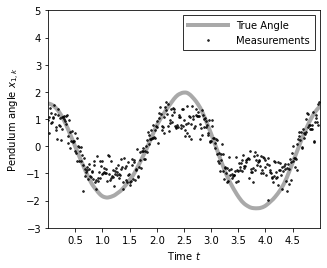

In [37]:
# Create time grid for plotting
time_grid = jnp.arange(0.0, 5.0, step=dt)

# Plot the generated data
plot_pendulum(time_grid, states[:,0], obs)

## 2. Simulation and Plotting

Next, we use a first-order EKF to estimate the angle of pendulum from the noisy measurements.

In [ ]:
# First order additive EKF (Algorithm 5.4)
def ekf_firstorder_additive(m_0, P_0, f, h, Q, R, Y):
    num_timesteps = len(Y)
    # Compute Jacobians
    F, H = jacfwd(f), jacfwd(h)

    def _step(carry, t):
        m_k, P_k = carry

        # Prediction step
        m_pred = f(m_k)
        P_pred = F(m_k) @ P_k @ F(m_k).T + Q

        # Update
        v = Y[t] - h(m_pred)
        S = jnp.atleast_2d(H(m_pred) @ P_pred @ H(m_pred).T + R)
        K = P_pred @ H(m_pred).T @ jnp.linalg.inv(S)
        m_post = m_pred + K @ v
        P_post = P_pred - K @ S @ K.T
        return (m_post, P_post), (m_post, P_post)
    
    carry = (m_0, P_0)
    _, (ms, Ps) = lax.scan(
        _step, carry, jnp.arange(num_timesteps)
    )
    return ms, Ps

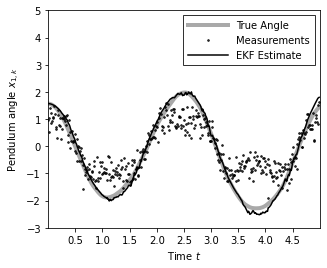

In [ ]:
# Additional params for EKF
m_0 = jnp.array([jnp.pi/2, 0])
P_0 = jnp.eye(2)*0.01

# Compute EKF estimates
m_ekf, P_ekf = ekf_firstorder_additive(m_0, P_0, f, h, Q, R, obs)

# Plot the generated data
plot.plot_pendulum(time_grid, states[:,0], obs, x_est=m_ekf[:,0], est_type="EKF")

Finally, we compute the RMSE of the EKF estimate.

In [ ]:
utils.compute_and_print_rmse_comparison(states[:,0], m_ekf[:,0], R, "EKF")

The RMSE of the EKF estimate is         : 0.14,
The std of measurement noise is         : 0.55


## 5.4 Statistically Linearized Filter

We use Algorithm 5.10 along with the closed-form expectations (5.70)~(5.73) to compute statistically linearized filter estimate for the simulated pendulum data.

In [ ]:
# Additive SLF (Algorithm 5.10)
def slf_additive(m_0, P_0, Ef, Efdx, Q, Eh, Ehdx, R, Y):
    num_timesteps = len(Y)

    def _step(carry, t):
        m_k, P_k = carry

        # Prediction step
        m_pred = Ef(m_k, P_k)
        P_pred = Efdx(m_k, P_k) @ jnp.linalg.inv(P_k) @ Efdx(m_k, P_k).T + Q

        # Update step
        v = Y[t] - Eh(m_pred, P_pred)
        S = jnp.atleast_2d(Ehdx(m_pred, P_pred) @ jnp.linalg.inv(P_pred) \
                           @ Ehdx(m_pred, P_pred).T + R)
        K = Ehdx(m_pred, P_pred).T @ jnp.linalg.inv(S)
        m_post = m_pred + K @ v
        P_post = P_pred - K @ S @ K.T

        return (m_post, P_post), (m_post, P_post)
    
    carry = (m_0, P_0)
    _, (ms, Ps) = lax.scan(
        _step, carry, jnp.arange(num_timesteps)
    )
    return ms, Ps

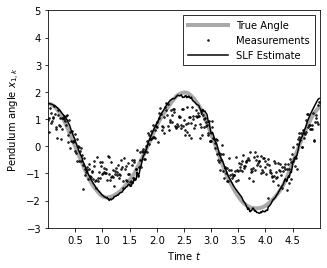

In [ ]:
# Params for SLF
Ef = lambda m, P: jnp.array([m[0]+m[1]*dt, 
                             m[1]-g*jnp.sin(m[0])*jnp.exp(-P[0,0]/2)*dt])
Eh = lambda m, P: jnp.array([jnp.sin(m[0])*jnp.exp(-P[0,0]/2)])
c11 = lambda m, P: P[0,0] + dt*P[0,1]
c12 = lambda m, P: P[0,1] + dt*P[1,1]
c21 = lambda m, P: P[0,1] - g*dt*jnp.cos(m[0])*P[0,0]*jnp.exp(-P[0,0]/2)
c22 = lambda m, P: P[1,1] - g*dt*jnp.cos(m[0])*P[0,1]*jnp.exp(-P[0,0]/2)
Efdx = lambda m, P: jnp.array([[c11(m,P), c12(m, P)],
                               [c21(m,P), c22(m, P)]])
Ehdx = lambda m, P: jnp.array([[jnp.cos(m[0])*P[0,0]*jnp.exp(-P[0,0]/2),
                                jnp.cos(m[0])*P[0,1]*jnp.exp(-P[0,0]/2)]])

# Compute SLF estimates
m_slf, P_slf = slf_additive(m_0, P_0, Ef, Efdx, Q, Eh, Ehdx, R, obs)

# Plot the generated data
plot.plot_pendulum(time_grid, states[:,0], obs, x_est=m_slf[:,0], est_type="SLF")

Finally, we compute the RMSE of the SLF estimate.

In [ ]:
utils.compute_and_print_rmse_comparison(states[:,0], m_slf[:,0], R, "SLF")

The RMSE of the SLF estimate is         : 0.14,
The std of measurement noise is         : 0.55


## 5.6 Unscented Kalman Filter

In [ ]:
# Additive UKF (Algorithm 5.14)
def ukf_additive(m_0, P_0, f, h, Q, R, alpha, beta, kappa, Y):
    num_timesteps, n = len(Y), P_0.shape[0]
    lamb = alpha**2 * (n + kappa) - n

    # Compute weights for mean and covariance estimates
    def compute_weights(n, alpha, beta, lamb):
        factor = 1/(2*(n+lamb))
        w_mean = jnp.concatenate((jnp.array([lamb/(n+lamb)]), 
                                  jnp.ones(2*n)*factor))
        w_cov = jnp.concatenate((jnp.array([lamb/(n+lamb) + (1-alpha**2+beta)]),
                                 jnp.ones(2*n)*factor))
        return w_mean, w_cov

    w_mean, w_cov = compute_weights(n, alpha, beta, lamb)

    def _step(carry, t):
        m_k, P_k = carry

        # Prediction step:
        # 1. Form sigma points
        sigmas_pred = compute_sigmas(m_k, P_k, n, lamb)
        # 2. Propagate the sigma points
        sigmas_pred = vmap(f, 0, 0)(sigmas_pred)
        # 3. Compute predicted mean and covariance
        m_pred = jnp.tensordot(w_mean, sigmas_pred, axes=1)
        outer = lambda x, y: jnp.atleast_2d(x).T @ jnp.atleast_2d(y)
        outer = vmap(outer, 0, 0)
        P_pred = jnp.tensordot(w_cov, 
                               outer(sigmas_pred-m_pred, sigmas_pred-m_pred), 
                               axes=1) + Q

        # Update step:
        # 1. Form sigma points
        sigmas_update = compute_sigmas(m_pred, P_pred, n, lamb)
        # 2. Propagate the sigma points
        sigmas_update_prop = vmap(h, 0, 0)(sigmas_update)
        # 3. Compute params
        mu = jnp.tensordot(w_mean, sigmas_update_prop, axes=1)
        S = jnp.tensordot(w_cov, 
                          outer(sigmas_update_prop-mu, sigmas_update_prop-mu), 
                          axes=1) + R
        C = jnp.tensordot(w_cov, 
                          outer(sigmas_update-m_pred, sigmas_update_prop-mu), 
                          axes=1)

        # 4. Compute posterior
        K = C @ jnp.linalg.inv(S)
        m_post = m_pred + K @ (Y[t] - mu)
        P_post = P_pred - K @ S @ K.T
        
        return (m_post, P_post), (m_post, P_post)

    # Find 2n+1 sigma points
    def compute_sigmas(m, P, n, lamb):
        disc = jnp.sqrt(n + lamb) * jnp.linalg.cholesky(P)
        sigma_plus = jnp.array([m + disc[:,i] for i in range(n)])
        sigma_minus = jnp.array([m - disc[:,i] for i in range(n)])
        return jnp.concatenate((jnp.array([m]), sigma_plus, sigma_minus))

    carry = (m_0, P_0)
    _, (ms, Ps) = lax.scan(
        _step, carry, jnp.arange(num_timesteps)
    )
    return ms, Ps

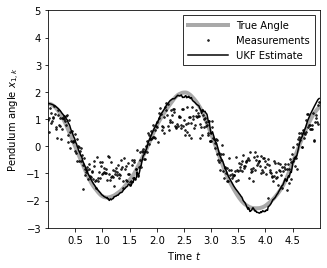

In [ ]:
# Params for UKF
alpha, beta, kappa = 1, 1, 2

# Compute SLF estimates
m_ukf, P_ukf = ukf_additive(m_0, P_0, f, h, Q, R, alpha, beta, kappa, obs)

# Plot the generated data
plot.plot_pendulum(time_grid, states[:,0], obs, x_est=m_ukf[:,0], est_type="UKF")

Finally, we compute the RMSE of the UKF estimate.

In [ ]:
utils.compute_and_print_rmse_comparison(states[:,0], m_ukf[:,0], R, "UKF")

The RMSE of the UKF estimate is         : 0.14,
The std of measurement noise is         : 0.55
